In [31]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [19]:
#from tensorflow.keras import mixed_precision
#mixed_precision.set_global_policy("mixed_float16")

In [20]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [21]:
def view_random_image(data):
    rand_cat = random.sample(list(train_data['category'].unique()),1)
    rand_img = random.sample(list(data[data['category']==rand_cat[0]]['image_path']),1)

    img = mpimg.imread(rand_img[0])
    plt.imshow(img)
    plt.title(rand_cat[0])
    plt.axis('off')

    print(f'Image shape: {img.shape}')

    return img

def loss_curves(cnn):
    loss = cnn.history['loss']
    val_loss = cnn.history['val_loss']

    accuracy = cnn.history['accuracy']
    val_accuracy = cnn.history['val_accuracy']

    epochs = range(len(cnn.history['loss']))

    plt.plot(epochs, loss, label= "training_loss")
    plt.plot(epochs, val_loss, label='validation_loss')
    plt.title('loss')
    plt.xlabel("epochs")
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label= "training_accuracy")
    plt.plot(epochs, val_accuracy, label='validation_accuracy')
    plt.title('accuracy')
    plt.xlabel("epochs")
    plt.legend()


## Load Train/Test Set

In [32]:
dir = '../data/food-101'
# Load the category labels
labels_file = dir+'/labels.txt'
with open(labels_file, 'r') as f:
    labels = [label.strip().lower().replace(' ', '_') for label in f.readlines()]

# Load the training dataset
train_file = dir+'/train.txt'
train_data = pd.read_csv(train_file, header=None, names=['category_filename'], dtype=str)
train_data['category'] = train_data['category_filename'].apply(lambda x: x.split('/')[0])
train_data['filename'] = train_data['category_filename'].apply(lambda x: x.split('/')[1])

# Add the '.jpg' extension to the filenames
train_data['filename'] = train_data['filename'].apply(lambda x: x + '.jpg')

# Construct the image paths
train_data['image_path'] = train_data.apply(lambda row: os.path.join(dir, 'images', row['category'], row['filename']), axis=1)

print (train_data.shape)

# Load the testing dataset
test_file = dir+'/test.txt'
test_data = pd.read_csv(test_file, header=None, names=['category_filename'], dtype=str)
test_data['category'] = test_data['category_filename'].apply(lambda x: x.split('/')[0])
test_data['filename'] = test_data['category_filename'].apply(lambda x: x.split('/')[1])

# Add the '.jpg' extension to the filenames
test_data['filename'] = test_data['filename'].apply(lambda x: x + '.jpg')

# Construct the image paths
test_data['image_path'] = test_data.apply(lambda row: os.path.join(dir, 'images', row['category'], row['filename']), axis=1)

print (test_data.shape)

(75750, 4)
(25250, 4)


Image shape: (512, 512, 3)


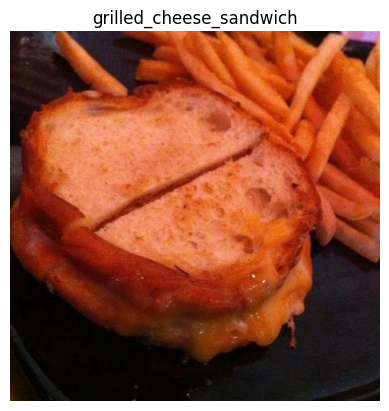

In [23]:
x = view_random_image(train_data)

## Preprocess Data

In [64]:
# Parameters for model training
input_shape = (224, 224, 3)
batch_size = 32

train_gen = ImageDataGenerator()

train_gen_aug = ImageDataGenerator(
                               rotation_range= 20,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True)

test_gen = ImageDataGenerator()


In [65]:
# load image categories and filepaths from dataframe
tf_train_data = train_gen.flow_from_dataframe(train_data,x_col='image_path',y_col='category',target_size=(224,224),batch_size=batch_size, classes=labels)
tf_train_data_aug = train_gen_aug.flow_from_dataframe(train_data,x_col='image_path',y_col='category',target_size=(224,224),batch_size=batch_size, classes=labels)

tf_test_data = test_gen.flow_from_dataframe(test_data,x_col='image_path',y_col='category',target_size=(224,224),batch_size=batch_size)


Found 75750 validated image filenames belonging to 101 classes.
Found 75750 validated image filenames belonging to 101 classes.
Found 25250 validated image filenames belonging to 101 classes.


## CNN Modeling

### MobileNet

In [76]:
input_shape = (224,224,3)
# Load MobileNet model without top layers and freeze the pre-trained layers
mobile_model = tf.keras.applications.mobilenet.MobileNet(include_top=False, input_shape=input_shape)
mobile_model.trainable = False


inputs = layers.Input(shape= input_shape, name='input_layer')

#x = layers.experimental.preprocessing.Rescaling(1./255)(x)
x = mobile_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(labels)) (x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.legacy.Adam(), metrics=['Accuracy'])

model.fit(tf_train_data_aug,
          epochs=1,
          steps_per_epoch=len(tf_train_data_aug),
          validation_data=tf_test_data,
          validation_steps=len(tf_test_data))


2023-07-24 20:44:16.341470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2368/2368 [==============================] - ETA: 0s - loss: 4.1857 - Accuracy: 0.0864

2023-07-24 21:03:24.029445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2368/2368 [==============================] - 1203s 508ms/step - loss: 4.1857 - Accuracy: 0.0864 - val_loss: 3.8985 - val_Accuracy: 0.1342


### ResNet50

In [71]:
resnet_model = tf.keras.applications.resnet.ResNet50(include_top=False, input_shape=(224, 224, 3))

resnet_model.trainable=False

inputs = layers.Input(shape= input_shape, name='input_layer')

#x = layers.experimental.preprocessing.Rescaling(1./255)(x)
x = resnet_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(labels)) (x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.legacy.Adam(), metrics=['Accuracy'])

model.fit(tf_train_data,
          epochs=1,
          steps_per_epoch=len(tf_train_data),
          validation_data=tf_test_data,
          validation_steps=len(tf_test_data))


2023-07-24 16:53:49.152593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2368/2368 [==============================] - ETA: 0s - loss: 2.5725 - Accuracy: 0.4006

2023-07-24 16:58:47.279009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2368/2368 [==============================] - 396s 167ms/step - loss: 2.5725 - Accuracy: 0.4006 - val_loss: 2.1385 - val_Accuracy: 0.4925


### EfficientNetB0

In [103]:
effb0_model = tf.keras.applications.EfficientNetB0(include_top=False)
effb0_model.trainable=False

inputs = layers.Input(shape= input_shape, name='input_layer')

#x = layers.experimental.preprocessing.Rescaling(1./255)(x)
x = effb0_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(labels)) (x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.legacy.Adam(), metrics=['Accuracy'])

model.fit(tf_train_data,
              epochs=10,
              steps_per_epoch=len(tf_train_data),
              validation_data=tf_test_data,
              validation_steps=int(0.10*len(tf_test_data)))



Epoch 1/10


2023-07-24 22:33:18.029644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2368/2368 [==============================] - ETA: 0s - loss: 1.7200 - Accuracy: 0.5813

2023-07-24 22:36:29.215733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2368/2368 [==============================] - 202s 84ms/step - loss: 1.7200 - Accuracy: 0.5813 - val_loss: 1.2465 - val_Accuracy: 0.6744
Epoch 2/10
2368/2368 [==============================] - 191s 81ms/step - loss: 1.2050 - Accuracy: 0.6886 - val_loss: 1.1475 - val_Accuracy: 0.7057
Epoch 3/10
2368/2368 [==============================] - 191s 81ms/step - loss: 1.0568 - Accuracy: 0.7241 - val_loss: 1.1160 - val_Accuracy: 0.7128
Epoch 4/10
2368/2368 [==============================] - 198s 84ms/step - loss: 0.9630 - Accuracy: 0.7464 - val_loss: 1.0791 - val_Accuracy: 0.7180
Epoch 5/10
2368/2368 [==============================] - 195s 82ms/step - loss: 0.8931 - Accuracy: 0.7633 - val_loss: 1.1173 - val_Accuracy: 0.7061
Epoch 6/10
2368/2368 [==============================] - 196s 83ms/step - loss: 0.8363 - Accuracy: 0.7783 - val_loss: 1.0694 - val_Accuracy: 0.7180
Epoch 7/10
2368/2368 [==============================] - 315s 133ms/step - loss: 0.7898 - Accuracy: 0.7903 - val_loss: 1.0975 - va

In [104]:
results = model.evaluate(tf_test_data)
results

790/790 [==============================] - 65s 81ms/step - loss: 1.1544 - Accuracy: 0.7166


[1.1543554067611694, 0.716633677482605]

### Xception

In [99]:
def preprocess_input_xception(data):
    return tf.keras.applications.xception.preprocess_input(data)

In [97]:
train_gen_x = ImageDataGenerator(preprocessing_function=preprocess_input_xception)

train_gen_aug_x = ImageDataGenerator(
    rotation_range= 20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input_xception)

test_gen_x = ImageDataGenerator(preprocessing_function=preprocess_input_xception)

# load image categories and filepaths from dataframe
tf_train_data_xcep = train_gen_x.flow_from_dataframe(train_data, x_col='image_path', y_col='category', target_size=(224, 224),
                                              batch_size=batch_size, classes=labels)
tf_train_data_aug_xcep = train_gen_aug_x.flow_from_dataframe(train_data, x_col='image_path', y_col='category',
                                                      target_size=(224, 224), batch_size=batch_size, classes=labels)

tf_test_data_xcep = test_gen_x.flow_from_dataframe(test_data, x_col='image_path', y_col='category', target_size=(224, 224),
                                            batch_size=batch_size)

Found 75750 validated image filenames belonging to 101 classes.
Found 75750 validated image filenames belonging to 101 classes.
Found 25250 validated image filenames belonging to 101 classes.


In [101]:
xcep_model = tf.keras.applications.xception.Xception(include_top=False, input_shape=(224, 224, 3))

xcep_model.trainable=False

inputs = layers.Input(shape= input_shape, name='input_layer')

#x = layers.experimental.preprocessing.Rescaling(1./255)(x)
x = xcep_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(labels)) (x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.legacy.Adam(), metrics=['Accuracy'])

model.fit(tf_train_data_xcep,
          epochs=10,
          steps_per_epoch=len(tf_train_data_xcep),
          validation_data=tf_test_data_xcep,
          validation_steps=int(0.10*len(tf_test_data_xcep)))

Epoch 1/10


2023-07-24 22:02:42.257346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2368/2368 [==============================] - ETA: 0s - loss: 2.1236 - Accuracy: 0.4719

2023-07-24 22:10:54.663246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2368/2368 [==============================] - 511s 215ms/step - loss: 2.1236 - Accuracy: 0.4719 - val_loss: 1.6958 - val_Accuracy: 0.5581
Epoch 2/10
2368/2368 [==============================] - 586s 247ms/step - loss: 1.6695 - Accuracy: 0.5678 - val_loss: 1.6697 - val_Accuracy: 0.5779
Epoch 3/10
2368/2368 [==============================] - 630s 266ms/step - loss: 1.5066 - Accuracy: 0.6047 - val_loss: 1.6511 - val_Accuracy: 0.5787
Epoch 4/10
 130/2368 [>.............................] - ETA: 7:47 - loss: 1.3387 - Accuracy: 0.6459

KeyboardInterrupt: 